In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### 1c1) **Bubble wake & shape**
The Reynolds number of a bubble in the TMHT channel is given by $$\mathrm{Re} = \frac{\rho_c U L}{\mu},$$ where:
- The density of water is $\rho_c=998.207$ $\text{kg/m}^3$ (at $20$ $\text{°C}$);
- The viscosity is $\mu=1.0016$ $\text{mPa s}$ (also at $20$ $\text{°C}$);
- The characteristic length scale is equal to the droplet diameter: $L=2.5*10^{-3}$ $\text{m}$ (like for a sphere in a fluid, see https://en.wikipedia.org/wiki/Reynolds_number#Sphere_in_a_fluid);
- The velocity is taken relative to liquid, i.e. $20 \%$ of the liquid velocity: $U=0.5$ $\text{m/s}$.

In [2]:
rho_c = 998.207     # kg/m^3
mu_c = 1.0016e-3    # Pa s
L = 2.5*1e-3        # m
U = 0.2*0.5         # m/s

Re = (rho_c * U * L) / mu_c
print(f'Re ≈ {Re:.0f}')

Re ≈ 249


We are not in the laminar regime. This means the wake of the bubble will create wirls behind the bubble, these wirls will cause the bubble to deform.

Next, the Bond (or Eötvös) number is $$\mathrm{Bo} = \frac{\Delta\rho g L^2}{\sigma},$$ where: (FOR THE BOND NUMBER wikipedia says to use the radius, not diameter?)
- The difference in density between the bubble and its surroundings $\Delta \rho = \rho_c - \rho_a$;
- The density of the air inside the bubble is $\rho_a=1.293$ $\text{kg/m}^3$ (at $20$ $\text{°C}$);
- Acceleration due to gravity $g=9.81$ $\text{m/s}^2$;
- The surface tension of water in air is $\sigma=72.8*10^{-3}$ $\text{N/m}$ (https://www.nanoscience.com/techniques/tensiometry/surface-and-interfacial-tension/).

In [16]:
rho_a = 1.293       # kg/m^3
g = 9.81            # m/s^2
sigma = 72.8e-3     # N/m

Bo = (rho_c - rho_a) * g * (L/**2) / sigma
print(f'Bo ≈ {Bo:.2f}')

Bo ≈ 0.21


The Morton number is given by $$\mathrm{Mo}=\frac{g \mu_c^4 \Delta\rho}{\rho_c^2 \sigma^3}.$$ We calculate the base 10 logarithm to check against the chart [Clift, R., Grace, J. R. & Weber, M. E. *Bubbles, drops, and particles*. (Dover Publ, 1978)]
given below.

In [6]:
from IPython.display import Image
Mo = g * mu_c**4 * (rho_c - rho_a) / (rho_c**2 * sigma**3)
print(f'log10(Mo) ≈ {np.log10(Mo):.1f}')

Image(filename='Re-Bo graph.png', width=400)

log10(Mo) ≈ -10.6


Using the Reynolds number and Bond (Eötvös) number, we can conclude from the chart that the bubbles will be slightly wobbly, and closer to ellipsoidal than to spherical, but definitely not cap-shaped. This point corresponds to a slightly lower value of $\text{log}_{10}(\text{Mo})$ than calculated, however. This might be due to underlying assumptions in the chart, but we have not looked further into this.

Regarding the wake, consider the sketch given below [Kong, G. et al. *Hydrodynamic interaction of bubbles rising side-by-side in viscous liquids*. Experiments in Fluids 60, (2019).]. These are bubbles with a slightly higher Bond number (between $1.50$ and $1.81$), but a Reynolds number of **(a)** $7.5$, **(b)** $84.9$, **(c)** $286.3$, and **(d)** $574.6$, respectively. Our bubbles will therefore most closely resemble case **(c)**, which is at the transition from a laminar to a turbulent wake, with vortices forming behind the bubbles.

In [7]:
Image(filename='Wake structure.png', width=400)

### 1c2) **Mean, standard error and PDF**
Start by calibrating the resistance measurements by fitting the Steinhart-Hart equation again.

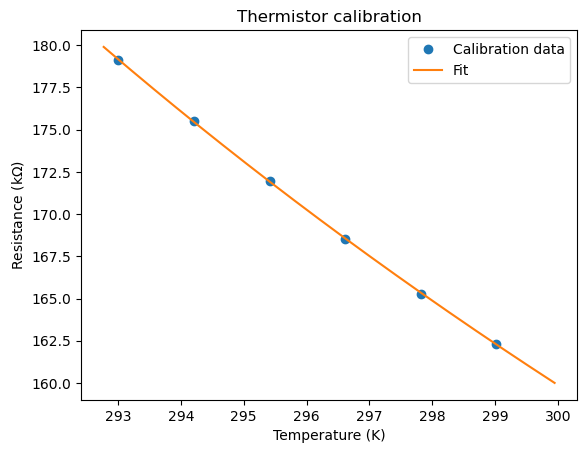

In [8]:
def steinhart_hart(R, A, B, C):
    T_inv = A + B * np.log(R) + C * (np.log(R)**3)
    return T_inv


def calc_temp(R, A, B, C):
    T = 1/steinhart_hart(R, A, B, C)
    return T


# Import data
[T_cal, R_cal] = np.squeeze(
    np.split(np.loadtxt('Data/ThermExperCalib.csv', delimiter=','), 2, axis=1))

# Fit the data
[A, B, C] = curve_fit(steinhart_hart, R_cal, 1/T_cal)[0]

# Plot
plt.plot(T_cal, R_cal/1000, 'o', label='Calibration data')

R_test = np.arange(160000, 180000, 100)
plt.plot(calc_temp(R_test, A, B, C), R_test/1000, label='Fit')
plt.legend()
plt.title('Thermistor calibration')
plt.xlabel('Temperature (K)')
plt.ylabel('Resistance (k$\Omega$)')
plt.show()

Next, we import the data, and calculate the temperature using the function defined above. We can directly obtain the mean and standard deviation of the signals.

In [9]:
# Import data
R_bub = np.loadtxt('Data/ThermBubData.csv', delimiter=',')
R_nobub = np.loadtxt('Data/ThermNoBubData.csv', delimiter=',')

# Calculate temperature
T_bub = calc_temp(R_bub, A, B, C)
T_nobub = calc_temp(R_nobub, A, B, C)

# Calculate and print statistics
T_mean_bub, T_std_bub = [np.mean(T_bub), np.std(T_bub)]
T_mean_nobub, T_std_nobub = [np.mean(T_nobub), np.std(T_nobub)]

print(f'Mean temperature (+- std) with bubbles: {T_mean_bub:.3f} +- {T_std_bub:.3f}'
    + f'\n                       without bubbles: {T_mean_nobub:.3f} +- {T_std_nobub:.3f}')

Mean temperature (+- std) with bubbles: 295.796 +- 0.032
                       without bubbles: 295.810 +- 0.035


Next, we calculate the PDFs, centre the bins that were output by the `np.histogram` function, and plot the results.

The number of bins in the histogram is chosen such that the graphs are smooth, without losing too much detail.

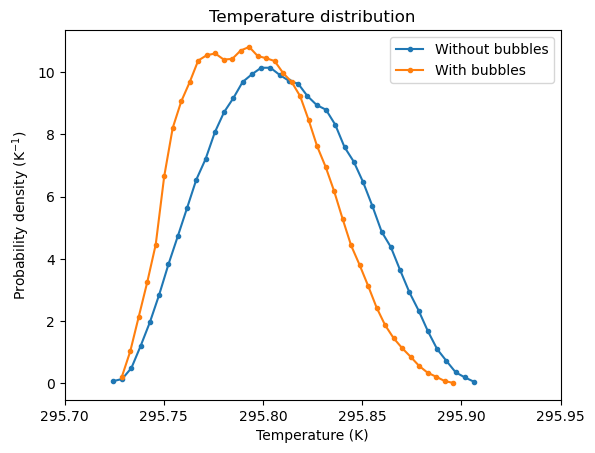

In [20]:
# Calculate the probabiliy density function of the data
n_bins = 40

pdf_bub, bins_bub = np.histogram(T_bub, bins=n_bins, density=True)
bin_centers_bub = 0.5*(bins_bub[1:] + bins_bub[:-1])

pdf_nobub, bins_nobub = np.histogram(T_nobub, bins=n_bins, density=True)
bin_centers_nobub = 0.5*(bins_nobub[1:] + bins_nobub[:-1])

plt.plot(bin_centers_nobub, pdf_nobub, '.-', label='Without bubbles')
plt.plot(bin_centers_bub, pdf_bub, '.-', label='With bubbles')

plt.xlim([295.7, 295.95])
plt.legend()
plt.title('Temperature distribution')
plt.xlabel('Temperature (K)')
plt.ylabel('Probability density (K$^{-1}$)')
plt.show()

It is clear that, even though the distribution itself is fairly similar (considering the mean and standard deviation), the temperature distribution is skewed slightly towards the colder side when bubbles are present in the channel.

We can check whether these PDFs are properly normalised: the probability of having *any* temperature should be equal to $100\%$, so $\int^{\infty}_{-\infty} PDF(x) \mathrm{d}x=1$.

In [11]:
print('The total probabilities of the above pdfs are '
      + str(np.sum(pdf_bub * (bins_bub[1] - bins_bub[0]))) + ' and '
      + str(np.sum(pdf_nobub * (bins_nobub[1] - bins_nobub[0]))) + ', respectively.')

The total probabilities of the above pdfs are 0.9999999999992225 and 0.999999999994177, respectively.


### 1c3) **Power spectra**

Below, we calculate the (averaged) power spectra of the two temperature signals. The number of pieces in which we have split the signal when applying the Bartlett method is such that as much noise as possible is averaged out, while still having sufficiently many data points to see the start of the inertial range (which is coloured grey) at around $1 \rm{Hz}$. 

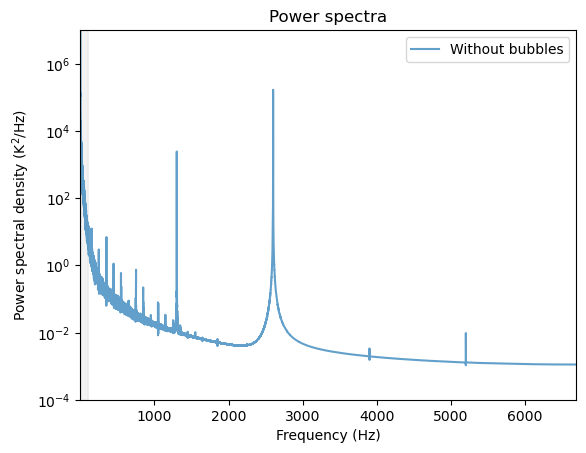

In [19]:
def bartlett_fft(signal, fs, n_pieces):
    # Cut the signal into n equally-sized pieces
    signal_list = np.split(signal, n_pieces)
    P_list = []

    # Calculate power spectrum of each piece
    for piece in signal_list:
        P_list.append(np.abs(np.fft.fft(piece))**2)

    # Calculate the average power spectrum
    P_av = np.mean(P_list, axis=0)

    # Calculate the frequency array
    f = np.fft.fftfreq(piece.size, 1/fs)
    idx = np.argsort(f)

    # Get only positive frequencies
    f, P_av = f[idx], P_av[idx]

    return f, P_av


fs = 13.39*1e3     # Hz
n_pieces = 10

f, PS_nobub = bartlett_fft(T_nobub, fs, n_pieces)
f, PS_bub = bartlett_fft(T_bub, fs, n_pieces)

f_slope = np.logspace(-2, 4, 100)
PS_slope = 25e4*f_slope**(-5/3)

fig, ax = plt.subplots()
#plt.loglog(f, PS_nobub, '-', alpha=0.7, label='Without bubbles')
plt.semilogy(f, PS_nobub, '-', alpha=0.7, label='Without bubbles')
#plt.loglog(f, PS_bub, '-', alpha=0.7, label='With bubbles')
#plt.loglog(f_slope, PS_slope, ':', color='k',
           #label='$E_T = 2.5*10^4*f^{-5/3}$')
ax.fill_between(f, 1e-4, 1e7, where=(f > 1) &
                (f < 100), color='gray', alpha=0.1)

plt.xlim([0.1, fs/2])
plt.ylim([1e-4, 1e7])
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (K$^2$/Hz)')
plt.title('Power spectra')
plt.show()

From the above plot, we can see that, in both cases, the power spectrum starts to decay faster than $E_T\propto f^{-5/3}$ at some point. This signifies the end of the inertial range. This onset occurs at lower frequencies when bubbles are present in the flow (around $5$ $\text{Hz}$ instead of $20$ $\text{Hz}$). In other words, the bubbles seem to dampen fast temperature oscillations.

Furthermore, two large peaks are present at the end of the spectrum. The largest peak is around 2600 Hz, this peak is from...

### 1c4) **Scalar quantities**

To distinguish other relevant scalar quantities, we consider again the dimensionless numbers that can be used to describe this system. Two examples include:
1. The surface tension (of the gas-liquid interface).
2. The viscocity of a fluid.
3. The density (of the liquid in the channel).

These three are not limited to this TMHT system and are relevant in many different systems. One could measure the surface tension of a liquid using a the pendant method. By using the shape of the drop, one can calculate the surface tension by fitting a set of formulas as the shape of the drop depens on the surface tension.\
The viscocity of a liquid could be measured with a viscometer. By measuring the force/torque needed to rotate a cylinder in a fluid, we can relate this to the viscocity of the liquid.